In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import trange

In [2]:
train_data = pd.read_csv('../../static/embeddings/multi_average_train.csv')
val_data = pd.read_csv('../../static/embeddings/multi_average_val.csv')

X = pd.concat([train_data.iloc[:, :-1], val_data.iloc[:, :-1]], axis=0)
y = pd.concat([train_data.iloc[:, -1:], val_data.iloc[:, -1:]], axis=0)


y.replace(1, 2, inplace=True)
y.replace(0, 1, inplace=True)
y.replace(-1, 0, inplace=True)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [4]:
def df_to_tensor(df):
    return torch.from_numpy(df.values).float()

In [5]:
X_train_t = torch.FloatTensor(df_to_tensor(X_train))
y_train_t = torch.LongTensor(y_train['label'].values.tolist())
X_val_t = torch.FloatTensor(df_to_tensor(X_val))
y_val_t = torch.LongTensor(y_val['label'].values.tolist())

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True)

In [7]:
def fit(epochs, model_, loss_func, opt, train_dl, valid_dl, lr_sched=None):
    model_ = model_.to(device)

    train_losses = []
    val_losses = []

    valid_accuracies = []

    pbar = trange(epochs, desc="Epoch:")
    for epoch in pbar:

        model_.train()
        loss_sum = 0

        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            probs = model_(xb)

            loss = loss_func(probs, yb)
            loss_sum += loss.item()
            loss.backward()

            opt.step()
            opt.zero_grad()

        train_losses.append(loss_sum / len(train_dl))


        model_.eval()
        loss_sum = 0
        correct = 0
        num = 0

        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                probs = model_(xb)

                loss = loss_func(probs, yb)
                loss_sum += loss.item()

                _, pred = torch.max(probs, axis=-1)
                correct += (pred == yb).sum().item()
                num += len(xb)


        val_loss = loss_sum / len(valid_dl)
        val_acc = correct / num
        val_losses.append(val_loss)
        valid_accuracies.append(val_acc)

        pbar.set_description('Epoch: {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, val_loss, val_acc))

        #torch.save(model.state_dict(), PATH)   #сохранение весов модели на будущее

        if lr_sched is not None:
            lr_sched.step()

    return train_losses, val_losses, valid_accuracies

Load Model:
    model = TheModelClass(*args, **kwargs)
    model.load_state_dict(torch.load(PATH))
    model.eval()

In [8]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        # Embedding size, Hyperparameter, Output
        self.fc1 = nn.Linear(300, 4096)
        self.fc2 = nn.Linear(4096, 3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
model = MultiLayerPerceptron().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

info = fit(64, model, criterion, optimizer, train_dataloader, val_dataloader, scheduler)

Epoch::   0%|          | 0/64 [00:00<?, ?it/s]

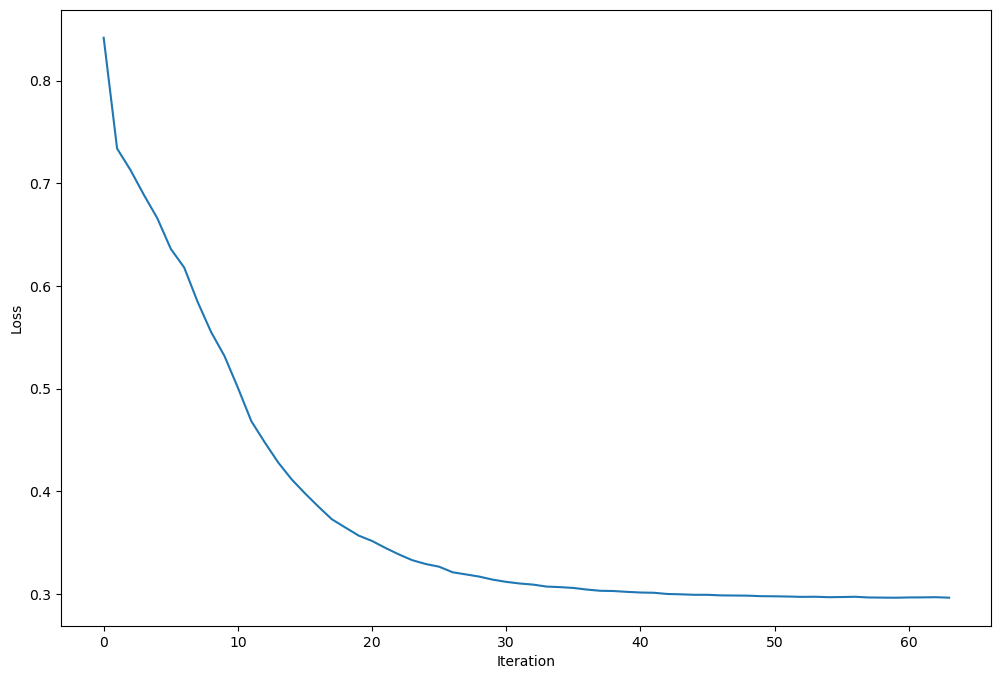

In [11]:
train_losses = info[0]
plt.figure(figsize=(12, 8))
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [12]:
import sys
sys.path.append('../..')

from src.metrics import multiclass_classification as multi_metrics

In [13]:
model.eval()
xb, yb = next(iter(val_dataloader))
probs = model(xb)
_, pred = torch.max(probs, axis=-1)

In [14]:
multi_metrics.f1_score(y_true=yb, y_pred=pred, average='macro')

0.5493520815896707